In [1]:
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import ase.io
import chemiscope
from pymatgen.core import Structure, Lattice, Composition

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_json('topoclass.json.gz')

In [3]:
df

ID subset MAT_TYPE TQC_TYPE  \
0      MAT00026906    M/T       TI     None   
1      MAT00020270    M/T      TrI     None   
2      MAT00015322    M/T    HSLSM     None   
3      MAT00025094    M/T      TCI     None   
4      MAT00025479    M/T    HSLSM     None   
...            ...    ...      ...      ...   
35603  MAT00038674    M&T      TrI    LCEBR   
35604  MAT00038675    M&T      TrI    LCEBR   
35605  MAT00038676    M&T      TrI    LCEBR   
35606  MAT00038677    M&T      TrI    LCEBR   
35607  MAT00038678    M&T      TrI    LCEBR   

                                               structure       MP_ID  ICSD_ID  \
0      {'@module': 'pymatgen.core.structure', '@class...    mp-10008      NaN   
1      {'@module': 'pymatgen.core.structure', '@class...  mp-1001604      NaN   
2      {'@module': 'pymatgen.core.structure', '@class...  mp-1001605      NaN   
3      {'@module': 'pymatgen.core.structure', '@class...  mp-1001844      NaN   
4      {'@module': 'pymatgen.core.structure', '@class...  mp-1002220      NaN   
...                                                  ...         ...      ...   
35603  {'@module': 'pymatgen.core.structure', '@class...   mp-696736  28541.0   
35604  {'@module': 'pymatgen.core.structure', '@class...   mp-707276  20730.0   
35605  {'@module': 'pymatgen.core.structure', '@class...   mp-707334  67509.0   
35606  {'@module': 'pymatgen.core.structure', '@class...   mp-707897  59327.0   
35607  {'@module': 'pymatgen.core.structure', '@class...     mp-9198  79005.0   

       AtomicOrbitals|HOMO_character  AtomicOrbitals|HOMO_element  \
0                                  1                           20   
1                                  2                           16   
2                                  4                           59   
3                                  2                            7   
4                                  2                           51   
...                              ...                          ...   
35603                              2                            9   
35604                              2                            7   
35605                              2                            8   
35606                              2                            8   
35607                              2                           15   

       AtomicOrbitals|HOMO_energy  ...  BondFractions|Ho - La bond frac.  \
0                       -0.141411  ...                                 0   
1                       -0.261676  ...                                 0   
2                       -0.155138  ...                                 0   
3                       -0.266297  ...                                 0   
4                       -0.185623  ...                                 0   
...                           ...  ...                               ...   
35603                   -0.415606  ...                                 0   
35604                   -0.266297  ...                                 0   
35605                   -0.338381  ...                                 0   
35606                   -0.338381  ...                                 0   
35607                   -0.206080  ...                                 0   

       BondFractions|Au - Pd bond frac.  BondFractions|Dy - Hg bond frac.  \
0                                     0                                 0   
1                                     0                                 0   
2                                     0                                 0   
3                                     0                                 0   
4                                     0                                 0   
...                                 ...                               ...   
35603                                 0                                 0   
35604                                 0                                 0   
35605                                 0    

In [4]:
classes = {"TrI": 0, "NTM": 1, "TI": 2, "TCI": 3, "HSPSM": 4, "HSLSM": 5}
mpe = "MaximumPackingEfficiency|max packing efficiency"
fpv = "ValenceOrbital|frac p valence electrons"
deltaH = "Miedema|Miedema_deltaH_inter"
mat_type = "MAT_TYPE"

In [5]:
X = df[[mpe,fpv]].values
X_scaled = StandardScaler().fit_transform(X)
tsne = TSNE(n_components=2, init='pca', random_state=0)
X_tsne = tsne.fit_transform(X_scaled)

In [6]:
df["tSNE_1"]=X_tsne[:,0]
df["tSNE_2"]=X_tsne[:,1]

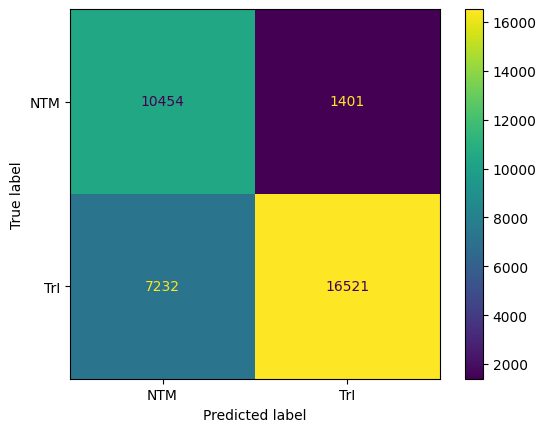

In [7]:
actual = (df[mat_type] == "TrI")
predicted = (df["tSNE_1"] > 0)
confusion_matrix = metrics.confusion_matrix(actual, predicted)
#TP = confusion_matrix[0,0]
#FP = confusion_matrix[1,0]
#FN = confusion_matrix[0,1]
#TN = confusion_matrix[1,1]
metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["NTM", "TrI"]).plot(values_format='')

In [8]:
print("Accuracy: ", metrics.accuracy_score(actual, predicted))
print("Precision:", metrics.precision_score(actual, predicted))
print("Recall:   ", metrics.recall_score(actual, predicted))
print("F1:       ", metrics.f1_score(actual, predicted))

Accuracy:  0.7575544821388452
Precision: 0.9218279209909608
Recall:    0.6955331958068455
F1:        0.7928494301139772


In [9]:
frames = []
for ind, row in df.iterrows():
    struc = Structure.from_dict(row["structure"])
    atoms = struc.to_ase_atoms()
    atoms.info = {
        "mat_id": ind,
        "mpe": row[mpe],
        "fpv": row[fpv],
        "deltaH": row[deltaH],
        "tSNE_1": -row["tSNE_1"],
        "tSNE_2": row["tSNE_2"],
        "mat_type_2": int(classes[row[mat_type]]>0),
        "mat_type_5": classes[row[mat_type]]
        }
    frames.append(atoms)

In [10]:
settings = chemiscope.quick_settings(x="tSNE_1", y="tSNE_2", color="mat_type_2")
settings["map"]["palette"]="viridis"
chemiscope.show(
    frames=frames,
    properties=chemiscope.extract_properties(frames),
    meta=dict(name="Topological classification"),
    settings=settings,
)

<ChemiscopeWidget(meta={'name': 'Topological classification'}, settings={'map': {'x': {'property': 'tSNE_1'}, …

In [11]:
chemiscope.write_input(
    "topoclass.chemiscope.json",
    frames=frames,
    properties=chemiscope.extract_properties(frames),
    meta=dict(name="Topological classification"),
    settings=settings,
)